In [159]:
from prometheus_api_client import PrometheusConnect, MetricsList, Metric, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime
from datetime import datetime, timedelta
import pprint
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
import argparse

In [160]:
import argparse
import sys

def parse_args():
    parser = argparse.ArgumentParser(description='Export sPHENIX lumi data from Time Series Database.')
    parser.add_argument('--start_time',  type=str, 
                        help='Start time in string', 
                        default="2024-08-1 00:00:00")
    parser.add_argument('--end_time',  type=str, 
                        help='End time in string', 
                        default="2024-08-6 00:00:00")
    parser.add_argument('--step',type=str,
                        default='60s',
                        help='Time bin step size')

    if 'ipykernel' in sys.modules:
        # Running in a Jupyter environment, use default values
        args = parser.parse_args([])
    else:
        # Running in a script, parse the command line arguments
        args = parser.parse_args()
    
    return args

args = parse_args()

# Which variable to read and its time range
start_time_input = args.start_time
end_time_input = args.end_time
step = args.step

# URL to read the database
database_url = 'http://db1.sphenix.bnl.gov:9090'

variable_map = {
    #CAD related
    'CAD_ZDC_NS': 'sphenix_cad_sisScaler_Hz{short_name="ZDC N·S"}',
    'CAD_ZDC_NS_Physics': 'sphenix_cad_sisScaler_Hz{short_name="ZDC N·S"}*on()(sphenix_cad_ssdash{short_name="rhicState",value="Physics"})',
    'CAD_ZDC_NS_GL1Run': 'sphenix_cad_sisScaler_Hz{short_name="ZDC N·S"} * on() (sphenix_rcdaq_file_size_Byte{hostname=~"gl1daq", filename=~".*physics.*"} > bool 0)',
    'CAD_ZDC_N': 'sphenix_cad_sisScaler_Hz {short_name="ZDC N Sum"}',
    'CAD_ZDC_S': 'sphenix_cad_sisScaler_Hz {short_name="ZDC S Sum"}',
    'BLUE_LANDAU_CAVITY_LOWERED': 'sphenix_cad_cavTuneLoop_V{device="cavTuneLoop.4a-rf-b197-1.3"} < bool 1e5',
    'N2yellow_Bgd': 'sphenix_cad_sisScaler_Hz{short_name="N2yellow"}',
    'S2blue_Bgd': 'sphenix_cad_sisScaler_Hz{short_name="S2blue"}',
    #GL1 rate
    'GL1_MBD_NS': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"10"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_MBD_S': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"8"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_MBD_N': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"9"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_ZDC_NS': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"3"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_ZDC_S': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"1"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_ZDC_N': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"2"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_MBD_Narrow': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"12"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_MBD_Jet': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"17"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_Jet': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"21"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_MBD_photon': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"25"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_MBD_photon': 'rate(sphenix_gtm_gl1_trigger_scalar{type="raw", gl1_trigger_id=~"29"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    'GL1_Trigger': 'rate(sphenix_gtm_gl1_register{register="23"}[1m])/on() group_left() rate(sphenix_gtm_gl1_bco[1m])*9.3831e6',
    

}
#ebdc
hostnames = [f'ebdc{str(i).zfill(2)}' for i in range(24)]
#intt
hostnames += [f'intt{str(i).zfill(2)}' for i in range(8)]
#mvtx
hostnames += [f'mvtx{str(i).zfill(2)}' for i in range(6)]
#seb
hostnames += [f'seb{str(i).zfill(2)}' for i in range(21)]
hostnames += ['gl1daq']
#query name pairs
daqrate_map = {}
for hostname in hostnames:
    daqrate_map[f'logging_rate_{hostname}'] = f'sphenix_rcdaq_file_size_Byte{{hostname="{hostname}"}}'

variable_map.update(daqrate_map)



In [161]:
# # Create a PrometheusConnect object to connect to the Prometheus API
prom = PrometheusConnect(url = database_url, disable_ssl=True)

# Convert the time range to datetime objects
start_time = parse_datetime(start_time_input)
end_time = parse_datetime(end_time_input)


print(f"start_time = {start_time} {start_time.__class__}")
print(f"end_time = {end_time} {end_time.__class__}")
print(f"step = {step} {step.__class__}")
print(f"end_time - start_time = {end_time - start_time} {(end_time - start_time).__class__}")
print(f"pd.Timedelta(step).to_pytimedelta() = {pd.Timedelta(step).to_pytimedelta()} {pd.Timedelta(step).to_pytimedelta().__class__}")

# 10,000 time steps limited by hard coded limit in prometheus
# https://github.com/prometheus/prometheus/blob/e9dec5fc537b1709f3a0e4c959043fb159b5d413/web/api/v1/api.go#L524
max_time_steps = 10000;
segment_start_time = start_time
segment_time_length = max_time_steps * pd.Timedelta(step).to_pytimedelta()
segment_end_time = end_time

time_segments = []
while segment_start_time + segment_time_length < end_time:
    segment_end_time = segment_start_time + segment_time_length
    time_segments.append((segment_start_time, segment_end_time))
    segment_start_time = segment_end_time
time_segments.append((segment_start_time, end_time))

for segment in time_segments:
    print(f"segment = {segment}")


results = {}

first_query = True

start_time = 2024-08-01 00:00:00 <class 'datetime.datetime'>
end_time = 2024-08-06 00:00:00 <class 'datetime.datetime'>
step = 60s <class 'str'>
end_time - start_time = 5 days, 0:00:00 <class 'datetime.timedelta'>
pd.Timedelta(step).to_pytimedelta() = 0:01:00 <class 'datetime.timedelta'>
segment = (datetime.datetime(2024, 8, 1, 0, 0), datetime.datetime(2024, 8, 6, 0, 0))


In [162]:
segment_df = None
for name, variable in variable_map.items():

    segment_first_query = True

    for segment in time_segments:
        
        segment_start_time = segment[0]
        segment_end_time = segment[1]

        print(f"{name}: Run the query for {variable} from {segment_start_time} ({segment_start_time.timestamp()}) to {segment_end_time}({segment_end_time.timestamp()}) in interval of {step}...")
        metric_data = prom.custom_query_range(
            variable,  # this is the metric name and label config
            start_time=segment_start_time,
            end_time=segment_end_time,
            step=step,
        )
        # print(metric_data)
        # print(len(metric_data))
        
        if len(metric_data) == 0:
            print (f"... Missing Valid Data. Skipping to next query.")            
            continue
        
        mr_df = MetricRangeDataFrame(metric_data, ts_as_datetime=False)
        data_series = mr_df['value']
        data_series.name = name
        print(data_series)
        if segment_first_query:
            segment_df = data_series.to_frame()
            segment_first_query = False
        else:            
            segment_df = pd.concat([segment_df, data_series.to_frame().iloc[1:, :] ]) 

    if first_query:
        first_query = False
        df = segment_df
        #reset segment_df
        segment_df = None
    elif segment_df is not None:
        df = df.join(segment_df, how='left', on='timestamp')
        #reset segment_df
        segment_df = None

df.fillna(0, inplace = True) 

# trick to add a '#' in the first line of the result CSV file
df.index.name = '# timestamp'

print("----------------------------------------")
print("Final results")
print("----------------------------------------")
print(df)

CAD_ZDC_NS: Run the query for sphenix_cad_sisScaler_Hz{short_name="ZDC N·S"} from 2024-08-01 00:00:00 (1722484800.0) to 2024-08-06 00:00:00(1722916800.0) in interval of 60s...
timestamp
1722484800    0.0
1722484860    0.0
1722484920    0.0
1722484980    0.0
1722485040    0.0
             ... 
1722916560    0.0
1722916620    0.0
1722916680    0.0
1722916740    0.0
1722916800    0.0
Name: CAD_ZDC_NS, Length: 7045, dtype: float64
CAD_ZDC_NS_Physics: Run the query for sphenix_cad_sisScaler_Hz{short_name="ZDC N·S"}*on()(sphenix_cad_ssdash{short_name="rhicState",value="Physics"}) from 2024-08-01 00:00:00 (1722484800.0) to 2024-08-06 00:00:00(1722916800.0) in interval of 60s...
timestamp
1722527040    38724.0
1722527100    38822.0
1722527160    38245.0
1722527220    37353.0
1722527280    37161.0
               ...   
1722912480    18945.0
1722912540    18932.0
1722912600    18930.0
1722912660    19091.0
1722912720    18233.0
Name: CAD_ZDC_NS_Physics, Length: 4037, dtype: float64
CAD_ZDC_NS_GL

In [166]:
df['timestamp'] = pd.to_datetime(df.index, unit='s')
df.head()

,CAD_ZDC_NS,CAD_ZDC_NS_Physics,CAD_ZDC_NS_GL1Run,CAD_ZDC_N,CAD_ZDC_S,BLUE_LANDAU_CAVITY_LOWERED,N2yellow_Bgd,S2blue_Bgd,GL1_MBD_NS,GL1_MBD_S,GL1_MBD_N,GL1_ZDC_NS,GL1_ZDC_S,GL1_ZDC_N,GL1_MBD_Narrow,GL1_MBD_Jet,GL1_Jet,GL1_MBD_photon,GL1_Trigger,logging_rate_ebdc00,logging_rate_ebdc01,logging_rate_ebdc02,logging_rate_ebdc03,logging_rate_ebdc04,logging_rate_ebdc05,logging_rate_ebdc06,logging_rate_ebdc07,logging_rate_ebdc08,logging_rate_ebdc09,logging_rate_ebdc10,logging_rate_ebdc11,logging_rate_ebdc12,logging_rate_ebdc13,logging_rate_ebdc14,logging_rate_ebdc15,logging_rate_ebdc16,logging_rate_ebdc17,logging_rate_ebdc18,logging_rate_ebdc19,logging_rate_ebdc20,logging_rate_ebdc21,logging_rate_ebdc22,logging_rate_ebdc23,logging_rate_seb00,logging_rate_seb01,logging_rate_seb02,logging_rate_seb03,logging_rate_seb04,logging_rate_seb05,logging_rate_seb06,logging_rate_seb07,logging_rate_seb14,logging_rate_seb15,logging_rate_seb16,logging_rate_seb17,logging_rate_seb18,logging_rate_seb20,logging_rate_gl1daq,timestamp
# timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1722484800,0.0,0.0,0.0,20.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.753900e+09,8.714000e+08,8.390000e+07,1.856398e+10,1.335900e+09,2.965100e+09,9.586000e+08,2.861900e+09,2.020850e+10,2.968400e+09,1.883446e+10,1.724600e+09,8.721000e+08,1.678275e+10,3.993400e+09,2.756200e+09,3.757500e+09,9.625000e+08,1.923400e+09,1.683000e+08,1.051500e+09,1.923900e+09,2.968600e+09,1.054400e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-08-01 04:00:00
1722484860,0.0,0.0,0.0,26.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.604700e+09,3.491400e+09,2.608600e+09,3.017000e+08,4.003300e+09,5.839200e+09,3.581300e+09,5.723800e+09,2.141000e+09,5.841100e+09,6.169000e+08,4.444900e+09,3.492800e+09,1.883255e+10,6.994600e+09,5.607200e+09,6.721100e+09,3.596400e+09,4.669000e+09,2.700200e+09,3.684600e+09,4.681400e+09,5.841600e+09,3.699100e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-08-01 04:01:00
1722484920,0.0,0.0,0.0,16.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.452000e+09,6.113000e+09,5.129100e+09,2.568000e+09,6.670600e+09,8.708800e+09,6.199700e+09,8.590400e+09,4.614700e+09,8.718700e+09,2.919500e+09,7.169700e+09,6.117900e+09,3.405000e+08,9.990900e+09,8.458200e+09,9.684700e+09,6.225900e+09,7.414800e+09,5.227800e+09,6.322100e+09,7.434300e+09,8.719300e+09,6.339500e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-08-01 04:02:00
1722484980,0.0,0.0,0.0,12.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.129940e+10,8.731600e+09,7.649700e+09,4.834300e+09,9.342400e+09,1.157820e+10,8.818300e+09,1.145230e+10,7.084400e+09,1.159140e+10,5.222200e+09,9.890000e+09,8.738800e+09,2.386900e+09,1.298710e+10,1.131390e+10,1.264820e+10,8.855400e+09,1.016500e+10,7.755500e+09,8.955300e+09,1.018730e+10,1.159230e+10,8.979800e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-08-01 04:03:00
1722485040,0.0,0.0,0.0,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.415150e+10,1.135020e+10,1.017020e+10,7.104300e+09,1.200980e+10,1.444840e+10,1.143640e+10,1.431420e+10,9.554100e+09,1.446420e+10,7.528700e+09,1.261020e+10,1.135960e+10,4.433300e+09,1.598340e+10,1.416490e+10,1.561670e+10,1.148920e+10,1.291080e+10,1.028320e+10,1.158840e+10,1.294020e+10,1.446530e+10,1.162020e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-08-01 04:04:00


In [167]:
from darts import TimeSeries
from darts.models import NBEATSModel, TFTModel, TransformerModel, NHiTSModel, TCNModel, ExponentialSmoothing
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)

frequency = 'T'

# Convert DataFrame to TimeSeries with specified frequency
series = TimeSeries.from_dataframe(df, time_col='timestamp', freq=frequency)
filler = MissingValuesFiller()
filled = filler.transform(series, method="linear")

In [170]:
series_length = len(filled)
print(f"The length of the time series is: {series_length}")

cut_index = int(series_length * 0.8)
train_series = filled[int(series_length * 0.098):cut_index]
val_series = filled[cut_index:]

# Target series (the series to predict)
#target_series = train_series[['GL1_Trigger', 'CAD_ZDC_NS_Physics']]
target_series = train_series[['GL1_Trigger']]
# Covariates (the rest of the series)
#covariates = train_series.drop_columns(['GL1_Trigger', 'CAD_ZDC_NS_Physics'])
covariates = train_series.drop_columns(['GL1_Trigger'])
#target_series['CAD_ZDC_NS_Physics'].plot(label='train')

The length of the time series is: 7201


In [171]:
from sklearn.preprocessing import MaxAbsScaler

# Normalize the series
scaler_target = Scaler(scaler=MaxAbsScaler())
scaler_covariates = Scaler(scaler=MaxAbsScaler())
target_series = scaler_target.fit_transform(target_series)
covariates = scaler_covariates.fit_transform(covariates)

# Split the data into train and validation sets
train_target, val_target = target_series.split_before(0.8)
train_covariates, val_covariates = covariates.split_before(0.8)

<AxesSubplot:xlabel='timestamp'>

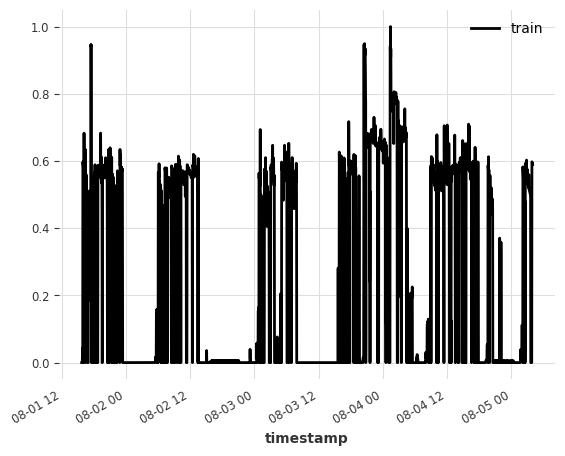

In [172]:

target_series.plot(label='train')

In [115]:
from darts.utils.likelihood_models import LaplaceLikelihood
model = TCNModel(
    input_chunk_length=60, 
    output_chunk_length=15, 
    pl_trainer_kwargs={"accelerator": "gpu", "devices": [0]},
    #likelihood=LaplaceLikelihood(),
)
#,past_covariates=covariates
# Fit the model
model.fit(train_target,
          past_covariates=covariates, 
          epochs=100, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_criterion | MSELoss          | 0     
2 | val_criterion   | MSELoss          | 0     
3 | train_metrics   | MetricCollection | 0     
4 | val_metrics     | MetricCollection | 0     
5 | res_blocks      | ModuleList       | 896   
-----------------------------------------------------
896       Trainable params
0         Non-trainable params
896       Total params
0.004     Total estimated model params size (MB)


Training: |                                                                         | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=60, output_chunk_length=15, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                       | 0/? [00:00<?, ?it/s]

<AxesSubplot:xlabel='timestamp'>

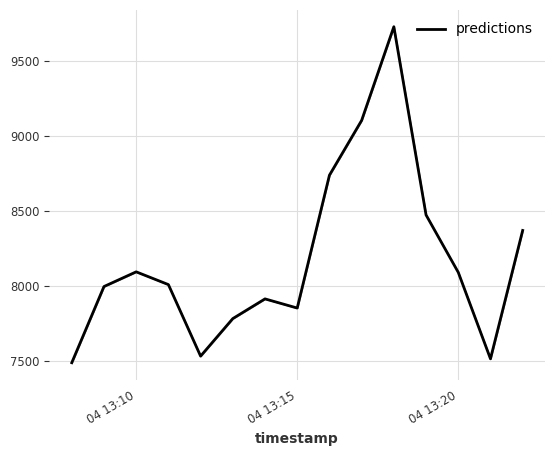

In [120]:
predictions = model.predict(series=val_target[:120],
                            past_covariates=val_covariates,
    n = 15, num_samples=1000)
#past_covariates=covariates
# Inverse transform the predictions
predictions = scaler_target.inverse_transform(predictions)
predictions.plot(label='predictions', low_quantile=0.1, high_quantile=0.9)

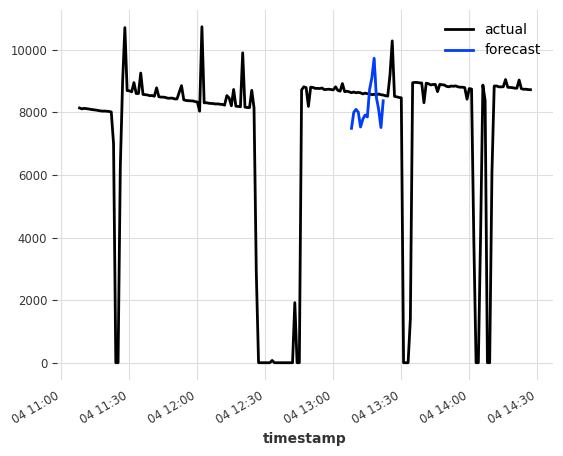

In [121]:
# Plot the results
actual_val = scaler_target.inverse_transform(val_target)
actual_val[:200].plot(label='actual')
predictions.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()